In this example we will be exploring the various ways to sample from a fairly simple line list with 100 lines (transmission evennts). There will be some building of trees (to see results) but we will be doing that the same way every time and just work on different ways to sample

## Looking at the Line List ##
We are going to import pandas to read in the line list as a dataframe. We will then look at the transmissions and metadata, make some plots, etc. This is just to help with expections of what different sampling frames should give.

In [51]:
import pandas as pd
lineList = pd.read_csv('100rows.csv')
lineList.head()

id  infectedById  timeInfected  timeSampled     sex location  age  risk
0   1            -1             0            5    male        A   29  high
1   2             1             8           13  female        A   31  high
2   3             1             5           10    male        A   36  high
3   4             2            12           15  female        A   28  high
4   5             2            16           20    male        A   41  high

Here we see that in addition to the infection information we also have the time sampled, the gender, a location, age, and risk category. Let us look at the distribution of the metadata.

<AxesSubplot:>

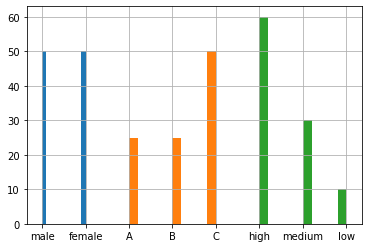

In [52]:
lineList['sex'].hist()
lineList['location'].hist()
lineList['risk'].hist()

<AxesSubplot:>

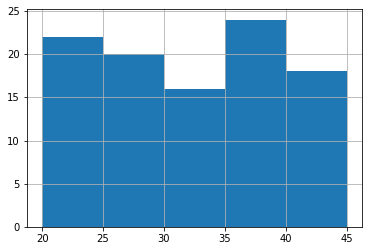

In [30]:
lineList['age'].hist(bins=[20,25,30,35,40,45])

In the above histograms the counts on the y-axis can be thought of as precentages because their are 100 rows.

While these distributions are fairly simple let us look at them conditioned on location.

<AxesSubplot:xlabel='location'>

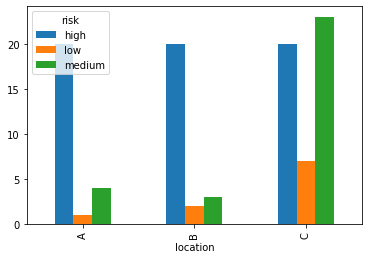

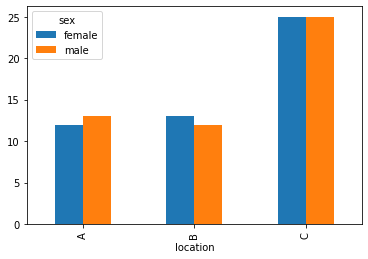

In [53]:
ag = lineList.groupby('location').risk.value_counts()
ag.unstack().plot(kind='bar')
ag = lineList.groupby('location').sex.value_counts()
ag.unstack().plot(kind='bar')

We can see that while the gender is split evenly in all locations the distribution of risk is very different in location C then A and B.

For good measure we will also look at histograms of the infection and sampling time.

<AxesSubplot:>

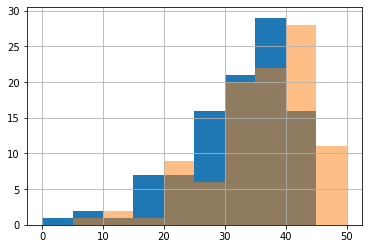

In [60]:
lineList['timeInfected'].hist(bins=[0,5,10,15,20,25,30,35,40,45,50])
lineList['timeSampled'].hist(bins=[0,5,10,15,20,25,30,35,40,45,50], alpha=0.5)

We can see that the sampling is delayed by about 5 days.

## Build the full tree

Here we will create a function that will build the tree for us passing in the line list and a list of sampled nodes that we can use over and over again. We will also create a function for plotting the tree with appropreate labels.

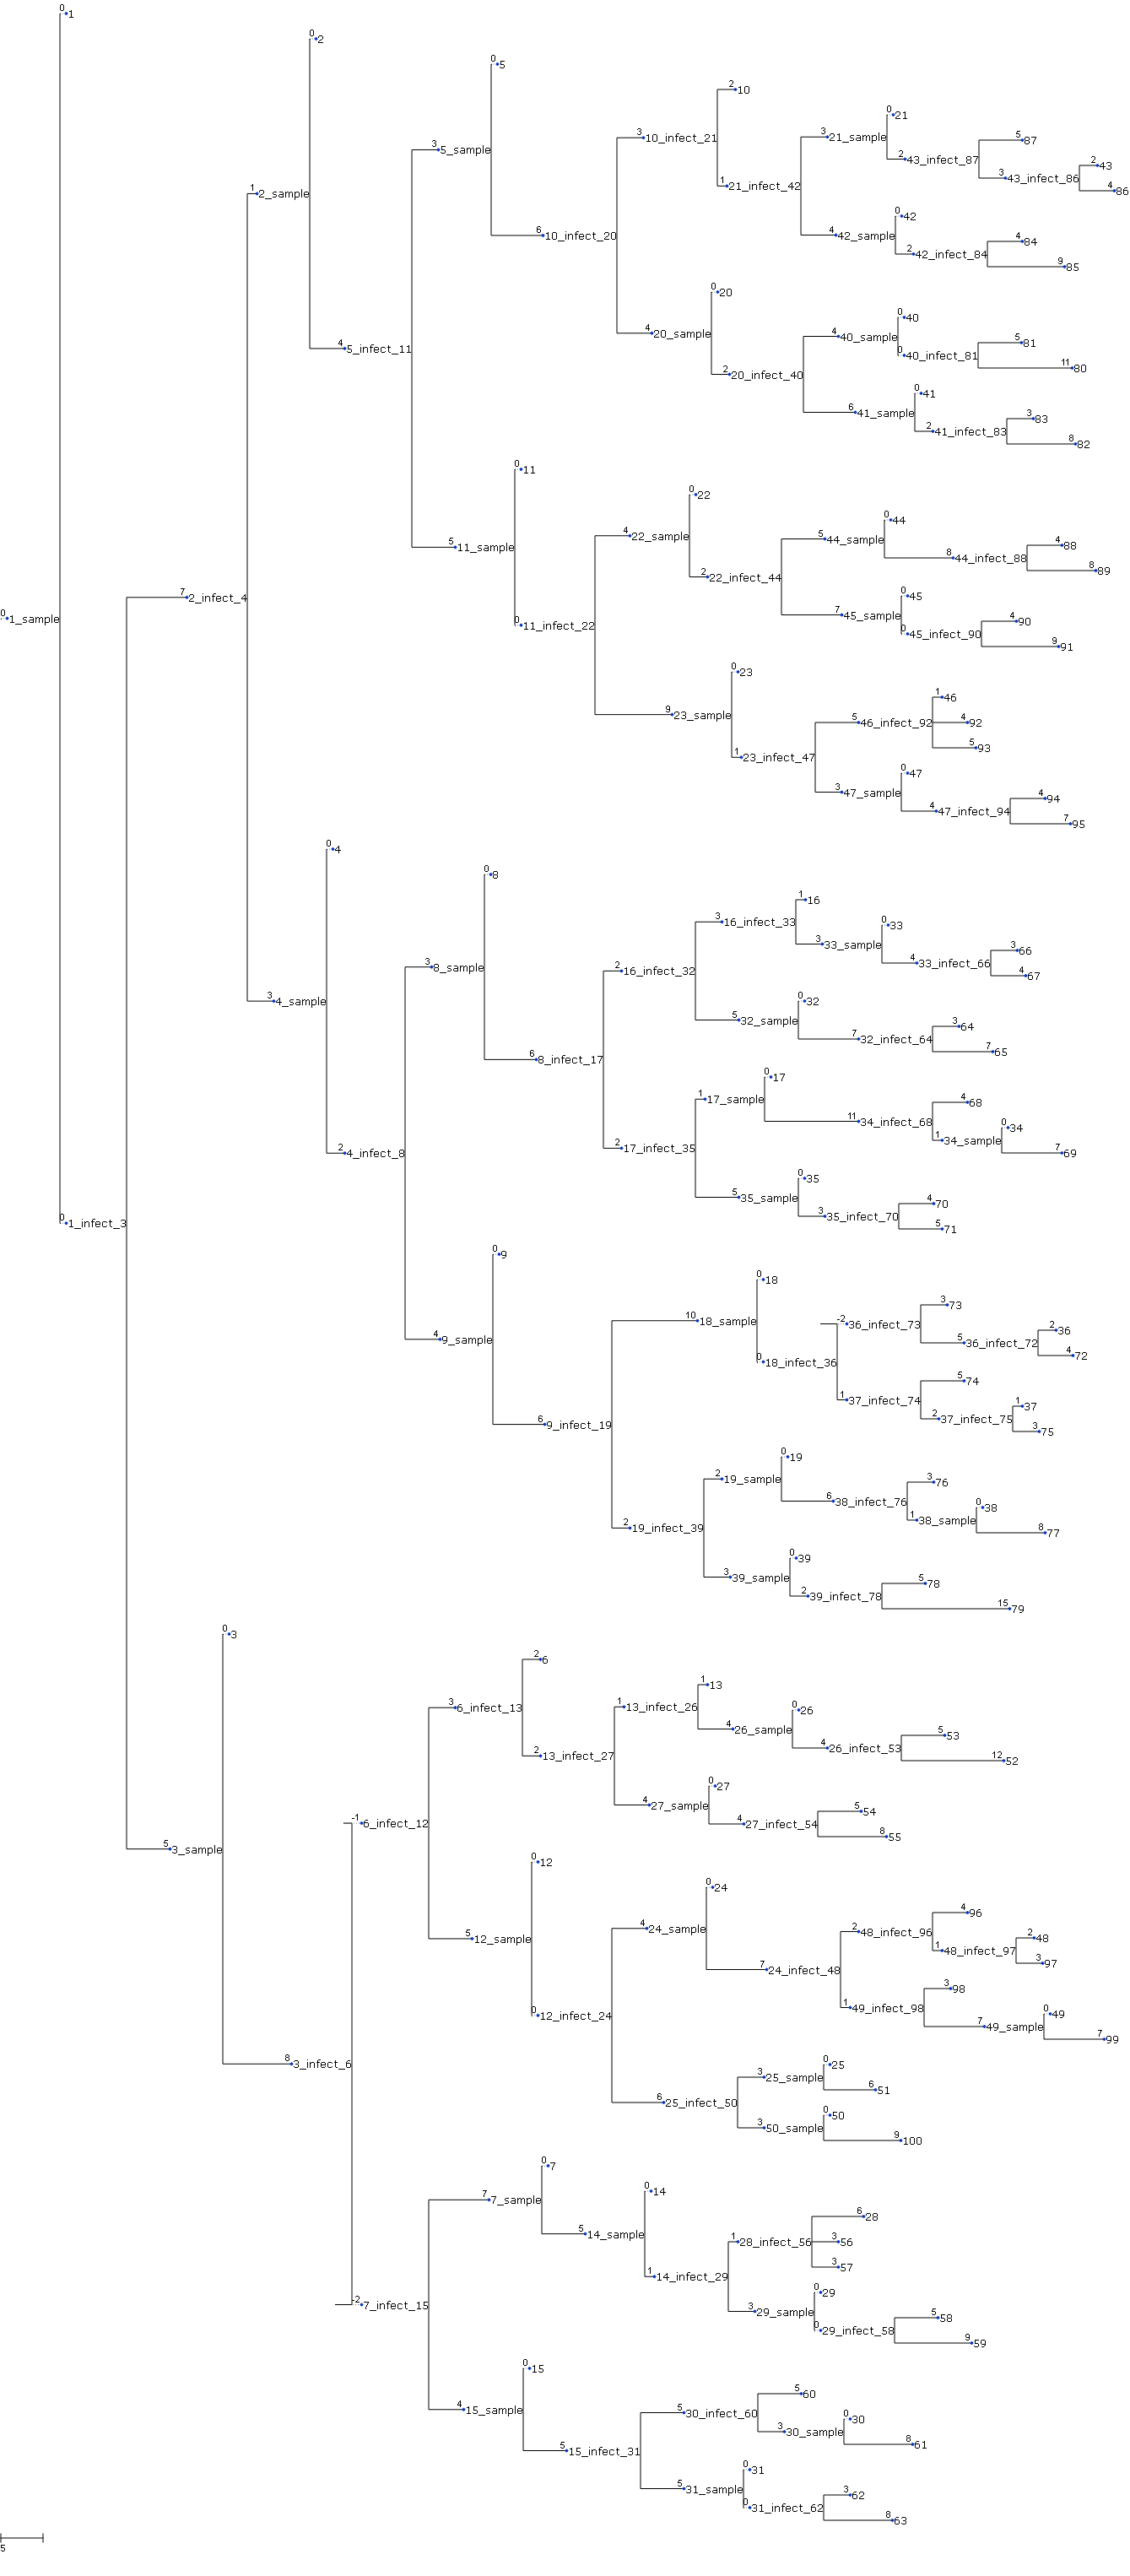

In [68]:
import numpy as np
from phylomodels.trees.generate_treeFromFile import read_treeFromLineList
from phylomodels.trees.transform_joinTrees import transform_joinTrees
from phylomodels.trees.transform_transToPhyloTree import transform_transToPhyloTree

def makeNewTree(lineList, sampledNodes=None):
    # make a copy of teh line list
    data = lineList.copy(deep=True)
    
    # remove sample time from the nodes not sampled
    if sampledNodes is not None:
        data.loc[~data['id'].isin(sampledNodes), 'sampledTime'] = np.nan
        
    # create the transmission tree
    trees = read_treeFromLineList(data, ID='id', infectorID='infectedById',
                                  infectTime='timeInfected', sampleTime='timeSampled',
                                  features=[])
    # for this particularly line list this is not needed because there is only one seed
    tree = transform_joinTrees(trees)
    # transform 
    tree = transform_transToPhyloTree(tree)
    
    return tree

def getTreeStyle(attr='name'):
    from ete3 import faces, AttrFace, TreeStyle, Tree

    def my_layout(node):
        if node.is_leaf():
             # If terminal node, draws its name
             name_face = AttrFace(attr)
        else:
             # If internal node, draws label with smaller font size
             name_face = AttrFace(attr, fsize=10)
        # Adds the name face to the image at the preferred position
        faces.add_face_to_node(name_face, node, column=0, position="branch-right")

    ts = TreeStyle()
    # Do not add leaf names automatically
    ts.show_leaf_name = False
    ts.show_branch_length = True
    ts.scale = 10
    # Use my custom layout
    ts.layout_fn = my_layout
    return ts

fullTree = makeNewTree(lineList)
fullTree.render('%%inline', tree_style=getTreeStyle())

## Sampling proportional to infection (Default option)

When sampling you can pass the information in a the name of a yaml file or a dictionary (which is what a yaml file is read in as). For this example we will use the dictionary so avoid having other files but we will format the dictionary to look like a yaml file.

Here we will provide the minimum possible sampling configuration which will sample proprotionally

No probability model type given for samplingFrame assuming proportional distribution


<AxesSubplot:>

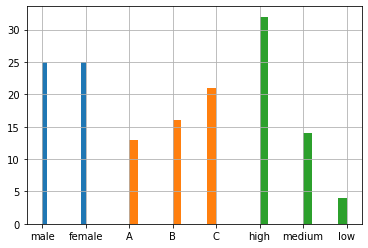

In [74]:
from phylomodels.sampling import sample_treeIndependent
config = {'dataRequested':
              {'numSamples': 50},
          'samplingFrame':
              {'variable': 'sex',
               'levels': ['male', 'female']
              }
         }

sampledNodes = sample_treeIndependent.runObservationModel(config, return_ids='id', lineList=lineList)

lineList.loc[lineList['id'].isin(sampledNodes), 'sex'].hist()
lineList.loc[lineList['id'].isin(sampledNodes), 'location'].hist()
lineList.loc[lineList['id'].isin(sampledNodes), 'risk'].hist()

Here we took 50 samples. We can look at the histograms to see that the distributions have not changed since we sampled proportional to infections. To do it properly we should do a chi squared test, but looking at it (when I ran at least) gender and risk looked identical to the first plots. Location does not look the same but I think it is within the expected statistical noise

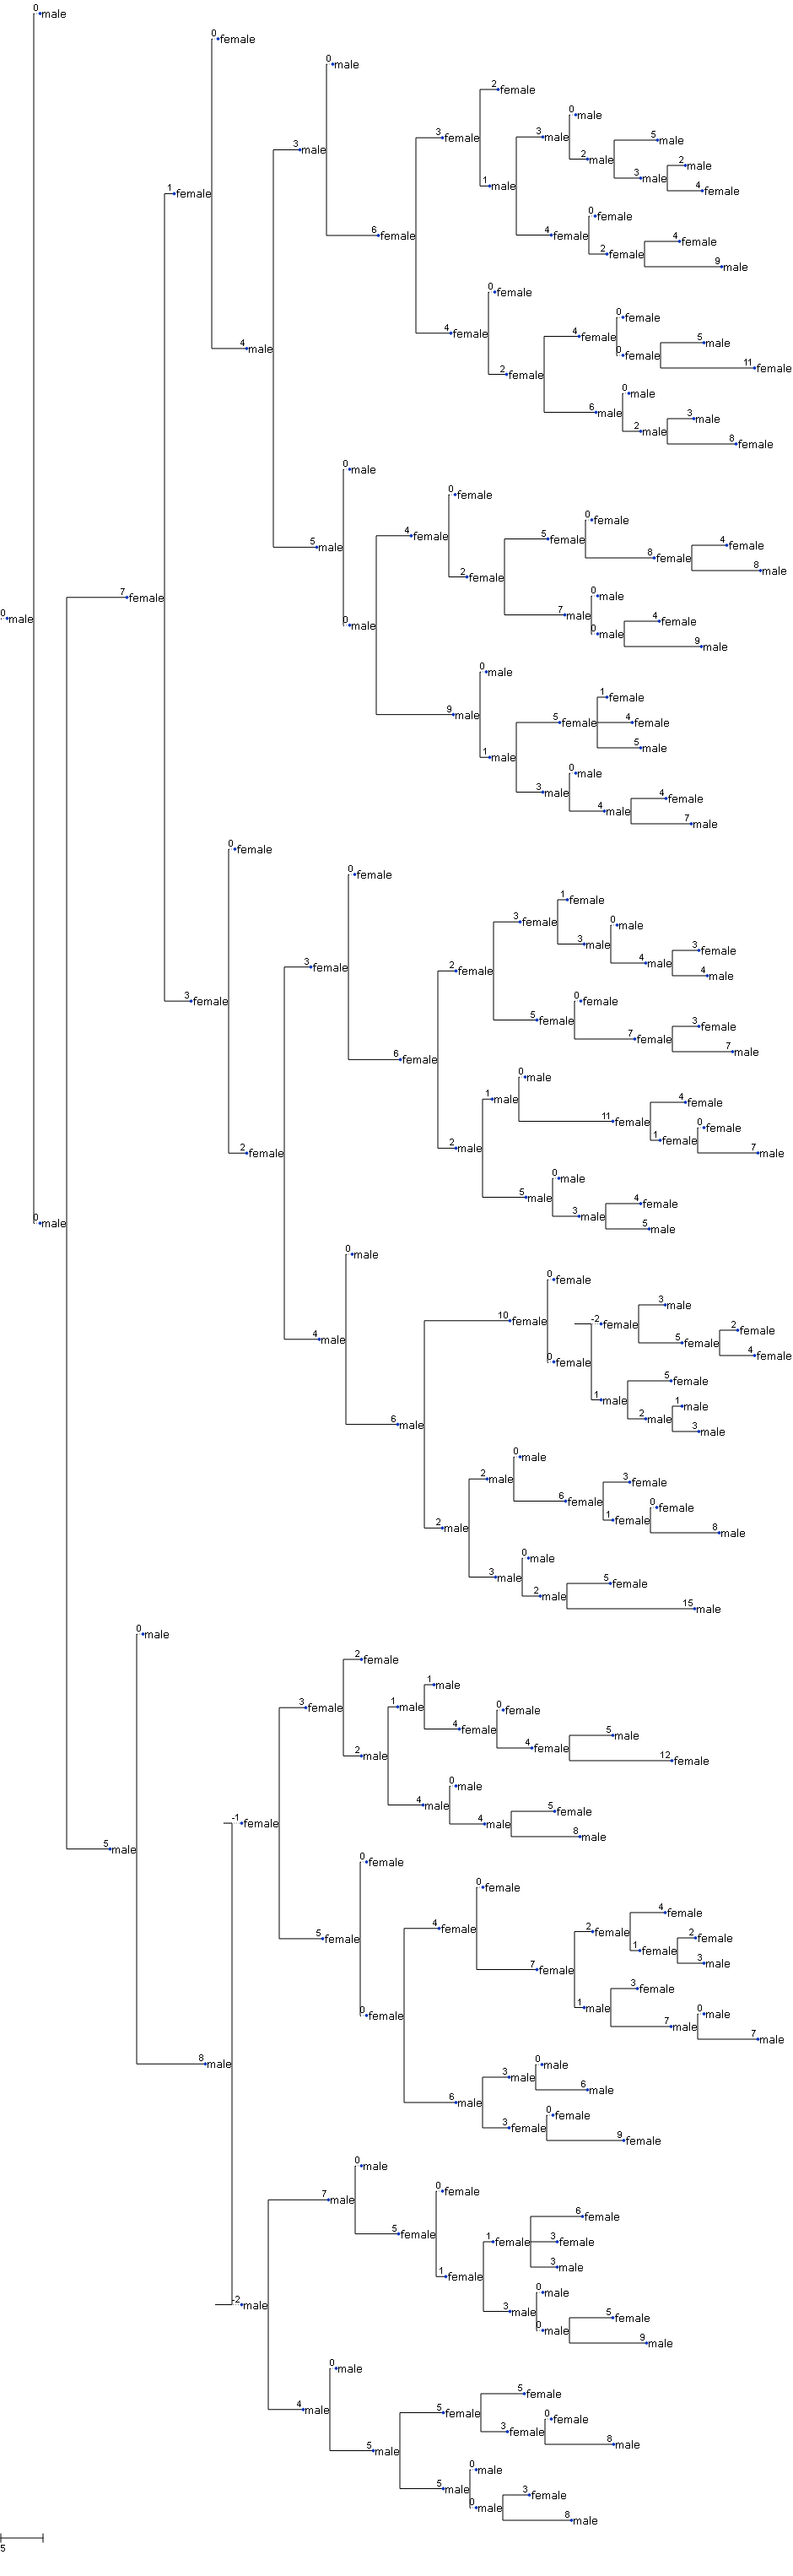

In [75]:
proportionalTree = makeNewTree(lineList, sampledNodes)
proportionalTree.render('%%inline', tree_style=getTreeStyle('sex'))

## Sampling uniformly from risk categories

Here we will take 30 samples and sample uniformly from the risk categories. We are only taking 30 samples because there are only 10 low risk people. I am not sure how this behaves if we try to take too many samples. That is something that needs to be addressed.

Here we will use the distribution name instead of specifying the probability values.

<AxesSubplot:>

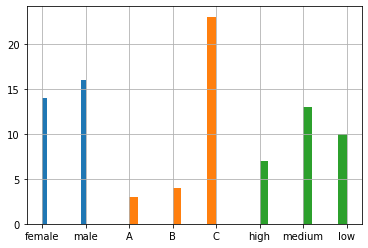

In [87]:
config = {'dataRequested':
              {'numSamples': 30},
          'samplingFrame':
              {'variable': 'risk',
               'levels': ['low', 'medium', 'high'],
               'probabilityModel':
                   {'type': 'uniformRandomSample'}
              }
         }

sampledNodes = sample_treeIndependent.runObservationModel(config, return_ids='id', lineList=lineList)

lineList.loc[lineList['id'].isin(sampledNodes), 'sex'].hist()
lineList.loc[lineList['id'].isin(sampledNodes), 'location'].hist()
lineList.loc[lineList['id'].isin(sampledNodes), 'risk'].hist()

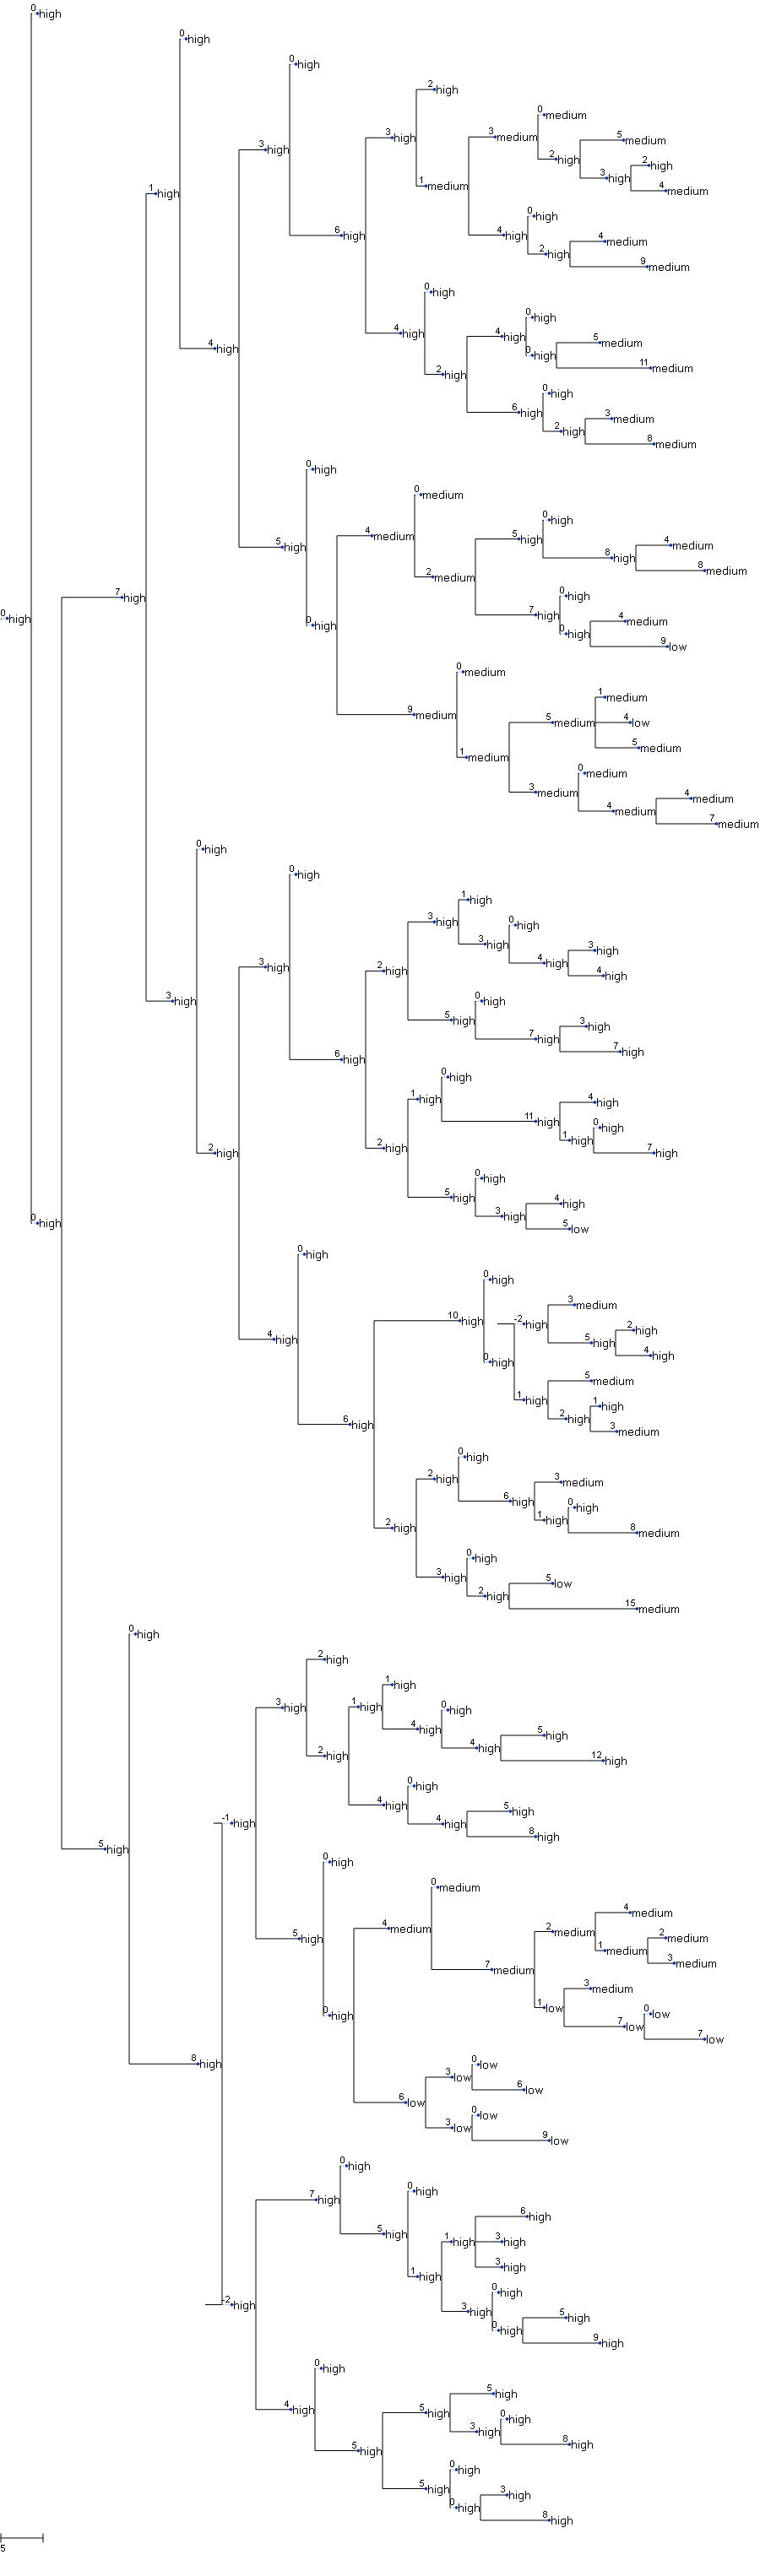

In [88]:
unifromTree = makeNewTree(lineList, sampledNodes)
unifromTree.render('%%inline', tree_style=getTreeStyle('risk'))

Here we can see that the risk categories are closer to even (with only 100 rows there is a lot of variability in the sampling). We also see that location C is enriched, which is expected as it is enriched in medium risk people.

## Sampling from multilevel custom distribution

For this last example we will create a mulitlevel sampling scheme. In doing this we are trying to show off some of the different ways you can set the probability distribution.

<AxesSubplot:>

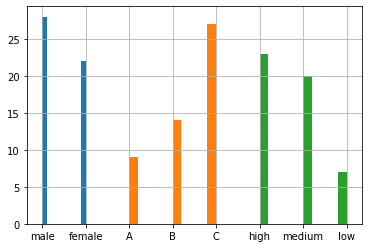

In [90]:
config = {'dataRequested':
              {'numSamples': 50},
          'samplingFrame':
              {'variable': 'sex',
               'levels': ['male', 'female'],
               'probabilityModel':
                   {'type': 'proportionalRandomSample'},
               'male':
                   {'variable': 'location',
                    'levels': {'A': 0.3, 'B': 0.2, 'C': 0.5}
                   },
               'female':
                   {'variable': 'risk',
                    'levels': ['low', 'medium', 'high'],
                    'probabilityModel':
                        {'probability': [0.5, 0.25, 0.25]}
                   }
              }
         }

sampledNodes = sample_treeIndependent.runObservationModel(config, return_ids='id', lineList=lineList)

lineList.loc[lineList['id'].isin(sampledNodes), 'sex'].hist()
lineList.loc[lineList['id'].isin(sampledNodes), 'location'].hist()
lineList.loc[lineList['id'].isin(sampledNodes), 'risk'].hist()

There probably is not much value in plotting this histogram, with only 100 lines in the full data we probably can expect a noticable signal when we sample this finely. Also I have not worked out what the expected values are for this example. Mostly it is just to show a more complicated example.

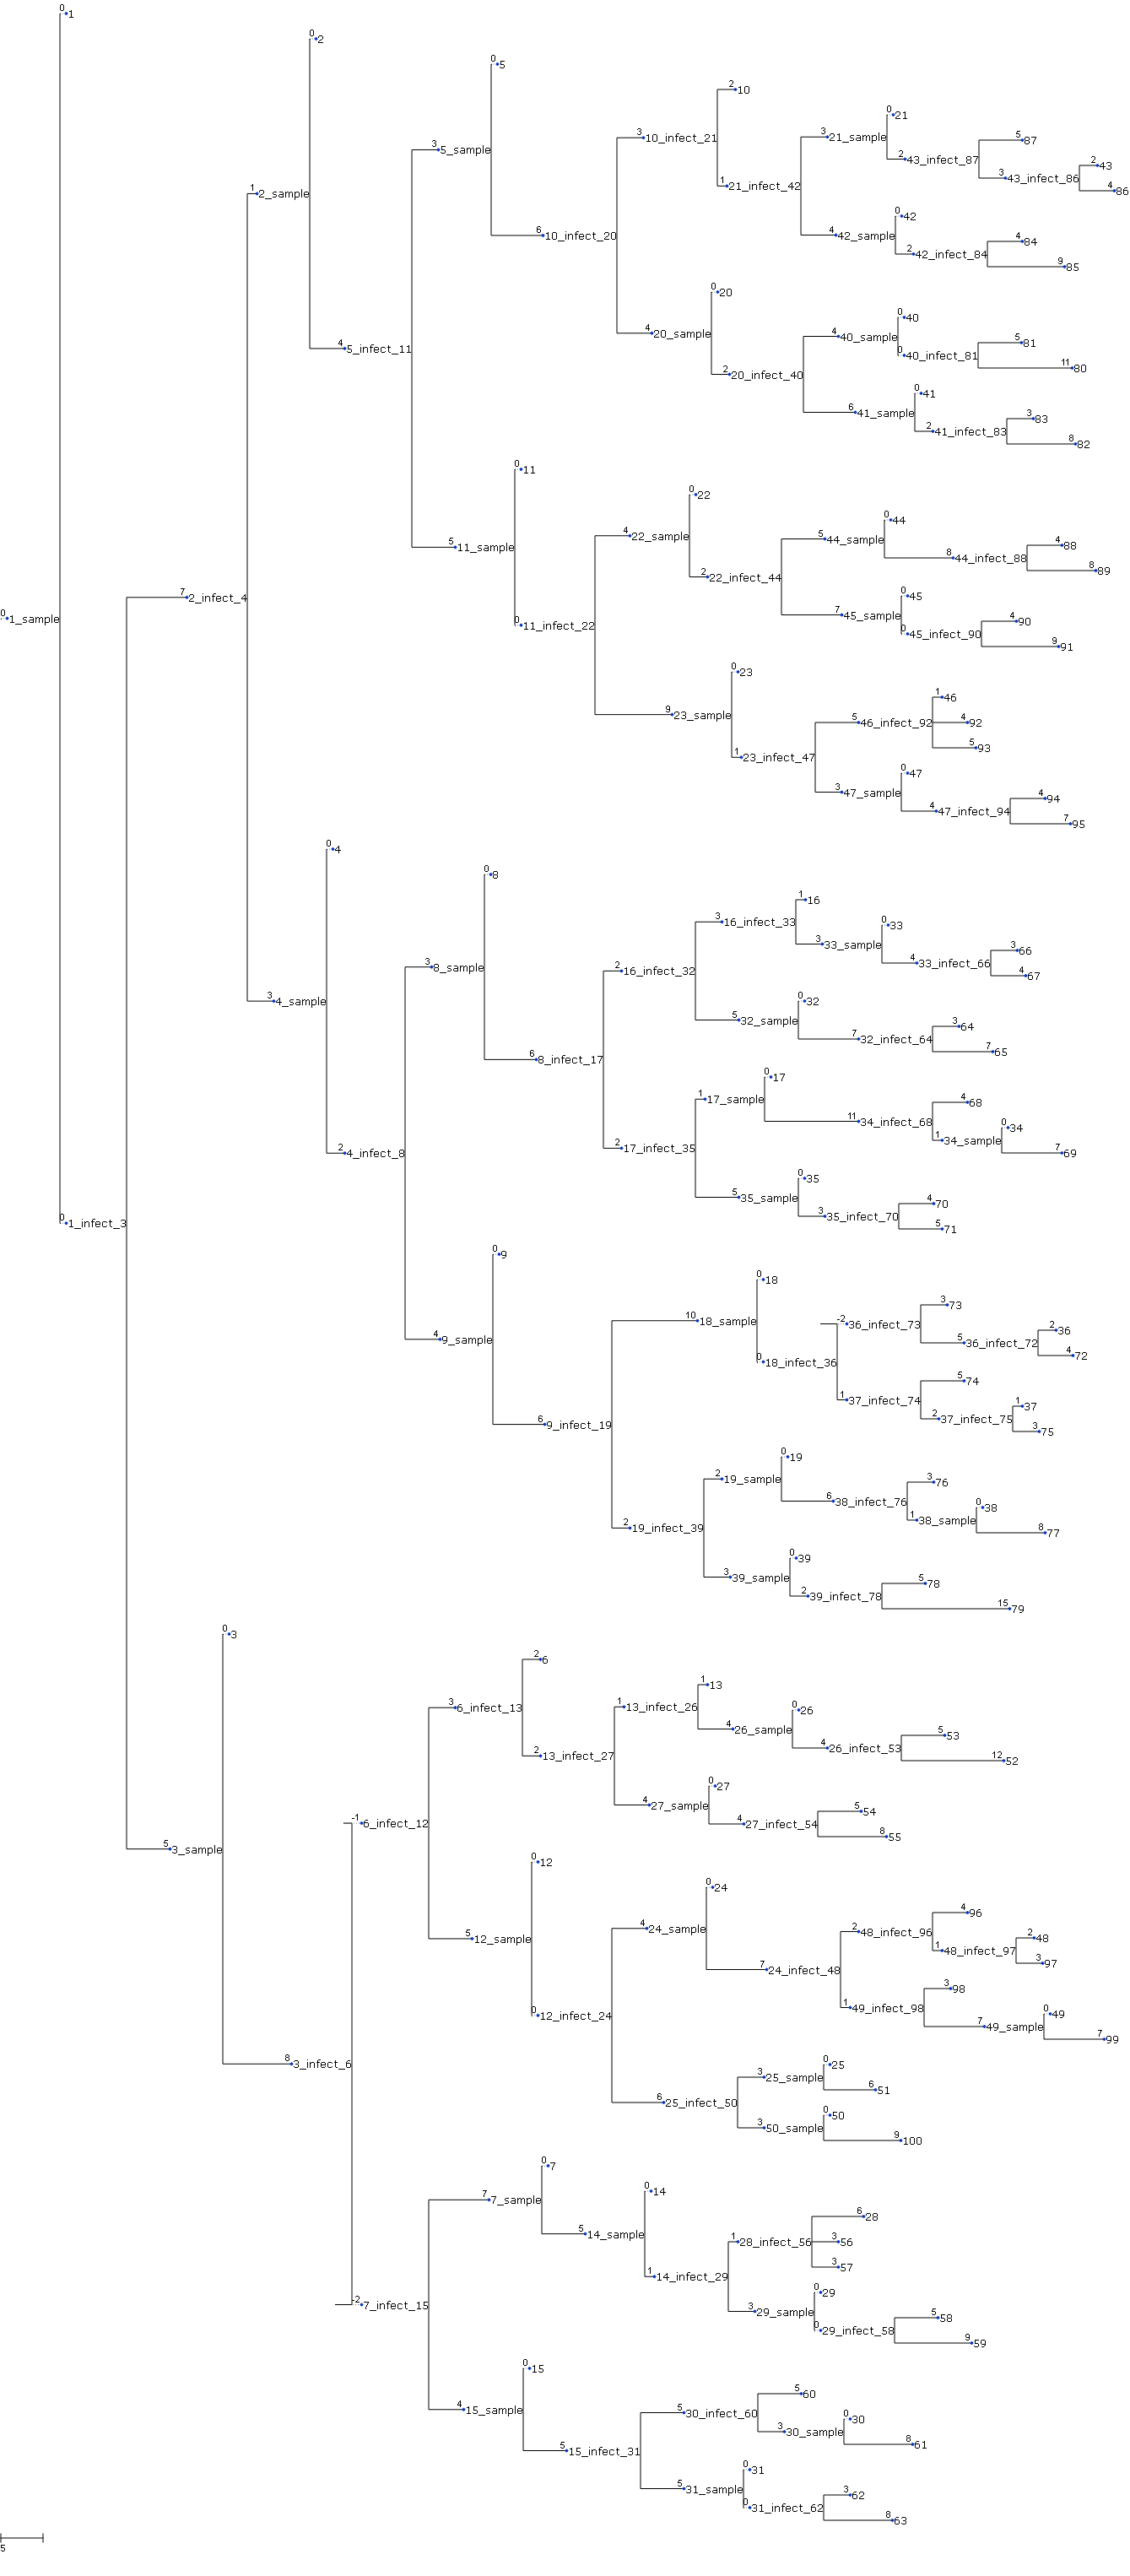

In [92]:
finalTree = makeNewTree(lineList, sampledNodes)
finalTree.render('%%inline', tree_style=getTreeStyle())